In [ ]:
import numpy as np
import pandas as pd
import random
import glob
import math
import xgboost
from sklearn import preprocessing

from matplotlib import pyplot


In [ ]:
# Get list of files for the Geo grouped data
data_files_list = glob.glob('/datasets/cms/MUP*Geo.csv')
data_files_list

# For training use 2013 to 2016 to predict 2017
# For testing use 2014 to 2017 to predict 2018
# for validation use 2015 to 2018 to predict 2019

# For presentation use 2016 to 2019 to predict 2020 (and compare against 2019)

['/datasets/cms/MUP_PHY_R19_P04_V10_D13_Geo.csv',
 '/datasets/cms/MUP_PHY_R19_P04_V10_D14_Geo.csv',
 '/datasets/cms/MUP_PHY_R19_P04_V10_D15_Geo.csv',
 '/datasets/cms/MUP_PHY_R19_P04_V10_D16_Geo.csv',
 '/datasets/cms/MUP_PHY_R19_P04_V10_D17_Geo.csv',
 '/datasets/cms/MUP_PHY_R20_P04_V10_D18_Geo.csv',
 '/datasets/cms/MUP_PHY_R21_P04_V10_D19_Geo.csv']

In [ ]:
df_geo_full = []
for _file in data_files_list:
    df_geo = pd.read_csv(
         _file,
         header=0, 
         #skiprows=lambda i: i>0 and random.random() > p
    )
    year= _file[-10:-8]
    df_geo['year'] = 2000+int(year)
    if len(df_geo_full)!=0:
        df_geo_full = df_geo_full.append(df_geo, ignore_index=False)
    else:
        df_geo_full = df_geo.copy()

df_geo_full= df_geo_full.loc[df_geo_full['year']!= 0,:]

excl_states =  ['Armed Forces Central/South America', 'Armed Forces Europe', 'Armed Forces Pacific', 'Foreign Country','National']
df_geo_full = df_geo_full.loc[~df_geo_full['Rndrng_Prvdr_Geo_Desc'].isin(excl_states),:].copy()

/shared-libs/python3.8/py-core/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3185: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [ ]:
# Prep geo_full for train/test/val

df_geo_features = df_geo_full.loc[:,['Rndrng_Prvdr_Geo_Desc', 'HCPCS_Cd', 'Tot_Srvcs','year']].copy()
df_geo_features = df_geo_features.groupby(['Rndrng_Prvdr_Geo_Desc', 'HCPCS_Cd','year'])[ 'Tot_Srvcs'].sum().reset_index()
df_geo_features.loc[:,'Tot_Srvcs'] = df_geo_features['Tot_Srvcs'].apply(lambda x: math.log(x))

df_geo_features.loc[:,'idx'] = df_geo_features.apply(lambda x:  "_".join([str(x['Rndrng_Prvdr_Geo_Desc']), str(x['HCPCS_Cd'])]), axis=1)
start_year = 2013
no_of_years = 4
df_geo_features.loc[:,'year'] = start_year + no_of_years - df_geo_features['year'] 
df_geo_features_train = df_geo_features.loc[df_geo_features['year']>=0,:].copy()
df_geo_features_train = df_geo_features_train.loc[df_geo_features_train['year'] <= no_of_years,:]

df_geo_features_test = df_geo_features.loc[df_geo_features['year']>=-1,:].copy()
df_geo_features_test.loc[:,'year'] = df_geo_features_test['year'] + 1
df_geo_features_test = df_geo_features_test.loc[df_geo_features_test['year']<=no_of_years,:].copy()

df_geo_features_train = df_geo_features_train.pivot(index=['idx'], columns=['year'], values='Tot_Srvcs')
df_geo_features_test = df_geo_features_test.pivot(index=['idx'], columns=['year'], values='Tot_Srvcs')

col_map = {
    0: "target",
    1: "1",
    2: "2",
    3: "3"
}

df_geo_features_train.rename(columns = col_map, inplace=True)
df_geo_features_test.rename(columns = col_map, inplace=True)

df_geo_features_train['state'] = df_geo_features_train.reset_index()['idx'].apply(lambda x: x.split("_")[0]).values
df_geo_features_test['state'] = df_geo_features_test.reset_index()['idx'].apply(lambda x: x.split("_")[0]).values

df_geo_features_train.reset_index(inplace=True)
df_geo_features_test.reset_index(inplace=True)

df_geo_features_train.fillna(0, inplace=True)
df_geo_features_test.fillna(0, inplace=True)

In [ ]:
df_geo_features_test.sample(5)

year,idx,target,1,2,3,4,state
33612,Connecticut_92014,12.018658,12.187272,12.169575,12.150560,12.163781,Connecticut
194376,South Carolina_62369,5.030438,5.308268,5.517453,5.799093,5.789960,South Carolina
28895,Colorado_92083,10.333092,10.273015,10.247680,10.226114,10.169997,Colorado
79686,Kansas_87276,3.218876,2.772589,3.401197,4.189655,4.317488,Kansas
39259,District of Columbia_67108,4.077537,3.465736,0.000000,2.397895,2.833213,District of Columbia


In [ ]:
df_geo_features_train.sample(5)

year,idx,target,1,2,3,4,state
172096,Oklahoma_43333,0.000000,0.000000,2.708050,0.000000,0.000000,Oklahoma
154872,New York_A9556,3.784190,4.343805,4.394449,4.605170,5.141664,New York
14996,Arkansas_58940,2.708050,3.044522,2.833213,2.484907,3.295837,Arkansas
70860,Indiana_93799,2.708050,0.000000,0.000000,0.000000,0.000000,Indiana
171905,Oklahoma_36800,5.252273,5.192957,5.164786,5.023881,4.787492,Oklahoma


In [ ]:
# Import population estimates data
pop_est = pd.read_csv("/datasets/cms/SC-EST2020-ALLDATA5.csv")

# Drop columns that is not needed for "one row" melting
pop_est.drop(['SUMLEV', 'REGION', 'DIVISION', 'STATE'], axis='columns', inplace=True)

In [ ]:
pop_est.sample(3)

,NAME,SEX,ORIGIN,RACE,AGE,CENSUS2010POP,ESTIMATESBASE2010,POPESTIMATE2010,POPESTIMATE2011,POPESTIMATE2012,POPESTIMATE2013,POPESTIMATE2014,POPESTIMATE2015,POPESTIMATE2016,POPESTIMATE2017,POPESTIMATE2018,POPESTIMATE2019,POPESTIMATE2020
23859,Connecticut,0,1,3,37,239,239,240,231,240,252,258,228,238,270,257,263,279
49265,Idaho,2,0,3,73,61,61,60,65,81,85,93,92,112,122,121,114,159
176726,Vermont,1,2,5,82,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
pop_est['age_category'] =  pop_est['AGE'].apply(lambda x: 1 if x >40  else 0) 
#pop_est['idx'] = pop_est.apply(lambda x:  "_".join([str(x['SEX']), str(x['ORIGIN']), str(x['RACE']), str(x['AGE'])]), axis=1)
pop_est.drop(['SEX', 'ORIGIN', 'RACE', 'AGE'], axis='columns', inplace=True)

In [ ]:
pop_agg_df = pop_est.copy()
pop_agg_df.drop(['CENSUS2010POP','ESTIMATESBASE2010'], axis = 'columns', inplace=True)

pop_agg_df = pd.melt(pop_agg_df,id_vars=['NAME','age_category'])

pop_agg_df.loc[:,'year'] = pop_agg_df['variable'].apply(lambda x: int(x[-4:]))
#popestimate df
pop_agg_df.drop(['variable'], axis='columns', inplace=True)

pop_agg_df = pop_agg_df.groupby(['NAME','age_category','year']).sum().reset_index()
# set t=0 for base year

# set year count to integers from 0 to x for train and test split
start_year = 2013
no_of_years = 4
pop_agg_df.loc[:,'year'] = start_year + no_of_years - pop_agg_df['year'] 
pop_train_df = pop_agg_df.loc[pop_agg_df['year']>0,:].copy()
pop_train_df = pop_train_df.loc[pop_train_df['year'] <= no_of_years,:]
pop_test_df = pop_agg_df.loc[pop_agg_df['year']>-1,:].copy()
pop_test_df.loc[:,'year'] = pop_test_df['year'] + 1
pop_test_df = pop_test_df.loc[pop_test_df['year'] <= no_of_years,:]

pop_train_df.loc[:,'idx'] = pop_train_df.apply(lambda x:  "_".join([str(x['age_category']), str(x['year'])]), axis=1)
pop_train_df = pop_train_df.pivot(index='NAME', columns=['idx'], values='value')

pop_test_df.loc[:,'idx'] = pop_test_df.apply(lambda x:  "_".join([str(x['age_category']), str(x['year'])]), axis=1)
pop_test_df = pop_test_df.pivot(index='NAME', columns=['idx'], values='value')

# normalise values based on train data only

_mean = pop_train_df.stack().mean()
_std = pop_train_df.stack().std()

pop_train_df = (pop_train_df-_mean)/_std
pop_test_df = (pop_test_df-_mean)/_std

pop_train_df.index.name = 'state'
pop_test_df.index.name = 'state'

pop_train_df.reset_index(inplace=True)
pop_test_df.reset_index(inplace=True)

In [ ]:
pop_train_df.sample(3)

idx,state,0_1,0_2,0_3,0_4,1_1,1_2,1_3,1_4
2,Arizona,0.196971,0.184604,0.173674,0.162167,-0.003810,-0.023994,-0.042012,-0.059042
17,Kentucky,-0.217616,-0.218388,-0.219366,-0.218949,-0.299604,-0.302682,-0.305719,-0.309545
8,District of Columbia,-0.751808,-0.754006,-0.756969,-0.759423,-0.798635,-0.799487,-0.800356,-0.801334


In [ ]:
pop_test_df.sample(3)

idx,state,0_1,0_2,0_3,0_4,1_1,1_2,1_3,1_4
23,Minnesota,-0.024673,-0.032363,-0.039062,-0.044455,-0.170073,-0.175552,-0.181244,-0.185465
41,South Dakota,-0.736274,-0.738188,-0.739969,-0.740969,-0.763757,-0.764751,-0.765655,-0.766213
22,Michigan,0.575498,0.571357,0.568785,0.569463,0.452120,0.448292,0.443766,0.440798


In [ ]:
full_train = df_geo_features_train.merge(pop_train_df, on='state',how='left').drop(['state'], axis = 1).set_index('idx')
full_test = df_geo_features_test.merge(pop_test_df, on='state',how='left').drop(['state'], axis = 1).set_index('idx')

In [ ]:
full_test.sample(5)

,target,1,2,3,4,0_1,0_2,0_3,0_4,1_1,1_2,1_3,1_4
idx,,,,,,,,,,,,,
New York_93925,10.922822,10.893530,10.904983,10.921884,10.889248,2.028074,2.041380,2.052940,2.056700,1.675851,1.671264,1.662135,1.653787
Texas_55040,6.150603,6.079933,6.025866,6.169611,6.059123,3.765884,3.715102,3.650929,3.569424,2.305769,2.248578,2.185494,2.123262
Colorado_75982,0.000000,0.000000,0.000000,4.574711,4.553877,0.018745,0.007310,-0.006639,-0.024039,-0.190727,-0.200887,-0.212898,-0.224931
Colorado_J9308,8.812843,0.000000,9.035987,0.000000,0.000000,0.018745,0.007310,-0.006639,-0.024039,-0.190727,-0.200887,-0.212898,-0.224931
North Carolina_99348,8.264621,7.985825,8.043021,7.907652,7.820841,0.653459,0.639570,0.624579,0.614615,0.451763,0.432220,0.410943,0.391585


In [ ]:
model = xgboost.XGBRegressor(colsample_bytree=0.4,
                 gamma=0,                 
                 learning_rate=0.07,
                 max_depth=7,
                 min_child_weight=0.05,
                 n_estimators=10000,                                                                    
                 reg_alpha=0.75,
                 reg_lambda=0.45,
                 subsample=0.6,
                 seed=117) 

In [ ]:
x_train = full_train.drop(["target"], axis=1)
y_train = full_train['target']
x_test = full_test.drop(["target"], axis=1)
y_test= full_test['target']

model.fit(x_train, y_train, eval_set=[(x_train, y_train),(x_test,y_test)], early_stopping_rounds=50)

[0]	validation_0-rmse:4.84790	validation_1-rmse:4.86943
[1]	validation_0-rmse:4.54846	validation_1-rmse:4.56917
[2]	validation_0-rmse:4.27973	validation_1-rmse:4.30053
[3]	validation_0-rmse:4.00897	validation_1-rmse:4.02979
[4]	validation_0-rmse:3.77635	validation_1-rmse:3.79621
[5]	validation_0-rmse:3.61908	validation_1-rmse:3.63946
[6]	validation_0-rmse:3.42753	validation_1-rmse:3.44735
[7]	validation_0-rmse:3.29808	validation_1-rmse:3.31745
[8]	validation_0-rmse:3.12546	validation_1-rmse:3.14376
[9]	validation_0-rmse:2.94928	validation_1-rmse:2.96757
[10]	validation_0-rmse:2.85188	validation_1-rmse:2.86958
[11]	validation_0-rmse:2.69176	validation_1-rmse:2.70866
[12]	validation_0-rmse:2.54730	validation_1-rmse:2.56374
[13]	validation_0-rmse:2.43488	validation_1-rmse:2.45008
[14]	validation_0-rmse:2.32920	validation_1-rmse:2.34357
[15]	validation_0-rmse:2.22734	validation_1-rmse:2.24063
[16]	validation_0-rmse:2.15035	validation_1-rmse:2.16402
[17]	validation_0-rmse:2.08006	validation

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.4, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.07, max_delta_step=0,
             max_depth=7, min_child_weight=0.05, missing=nan,
             monotone_constraints='()', n_estimators=10000, n_jobs=2,
             num_parallel_tree=1, predictor='auto', random_state=117,
             reg_alpha=0.75, reg_lambda=0.45, scale_pos_weight=1, seed=117,
             subsample=0.6, tree_method='exact', validate_parameters=1,
             verbosity=None)

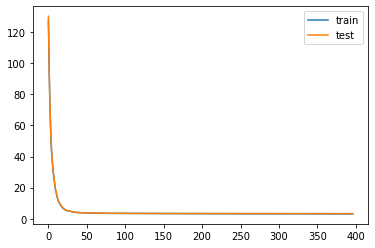

In [ ]:
results = model.evals_result()
# plot learning curves
_train_results = np.array(list(map(math.exp,results['validation_0']['rmse'])))
_test_results = np.array(list(map(math.exp,results['validation_1']['rmse'])))
pyplot.plot(_train_results, label='train')
pyplot.plot(_test_results, label='test')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [ ]:
y_pred = model.predict(x_test)

In [ ]:
full_test['state'] = full_test.reset_index()['idx'].apply(lambda x: x.split("_")[0]).values

In [ ]:
def perc_round(x):
    return round(x,-2)

full_test['pred'] = np.array(list(map(math.exp,y_pred)))
full_test['target_original'] = np.array(list(map(math.exp,full_test['target'])))
full_test['total_diff'] = np.array(list(map(round, full_test['target_original'] - full_test['pred'])))
full_test['perc_diff'] = full_test['total_diff'].values/full_test['target_original'].values

In [ ]:
full_test.sample(15)

,target,1,2,3,4,0_1,0_2,0_3,0_4,1_1,1_2,1_3,1_4,state,pred,target_original,total_diff,perc_diff
idx,,,,,,,,,,,,,,,,,,
Oklahoma_97033,0.000000,0.000000,4.584967,4.779123,0.000000,-0.226620,-0.226902,-0.229508,-0.236450,-0.382753,-0.385034,-0.388473,-0.391567,Oklahoma,1.977476,1.0,-1,-1.000000
Louisiana_44360,5.517453,5.541264,5.525453,5.209486,5.605802,-0.155642,-0.151802,-0.152418,-0.155233,-0.299834,-0.302152,-0.306059,-0.309669,Louisiana,234.252241,249.0,15,0.060241
Iowa_61797,3.526361,0.000000,0.000000,0.000000,3.401197,-0.401122,-0.403392,-0.405209,-0.408003,-0.473787,-0.474962,-0.476538,-0.477528,Iowa,2.298014,34.0,32,0.941176
Virginia_71030,0.000000,5.252273,4.983607,4.905275,5.105945,0.417973,0.410374,0.404800,0.398453,0.206701,0.197277,0.186812,0.176805,Virginia,165.018981,1.0,-164,-164.000000
Hawaii_73020,6.395262,6.340359,5.676754,5.411646,5.308268,-0.574385,-0.572939,-0.573450,-0.575063,-0.652140,-0.653734,-0.655994,-0.657801,Hawaii,425.727974,599.0,173,0.288815
California_G0143,5.837730,5.153292,0.000000,0.000000,0.000000,5.445280,5.431557,5.412786,5.376525,3.914986,3.867405,3.809419,3.748269,California,184.987239,343.0,158,0.460641
Ohio_21081,3.526361,3.332205,3.258097,2.944439,2.708050,0.832752,0.826685,0.824107,0.820466,0.658330,0.655124,0.650665,0.647816,Ohio,24.133390,34.0,10,0.294118
Michigan_J3120,0.000000,0.000000,0.000000,0.000000,6.453625,0.575498,0.571357,0.568785,0.569463,0.452120,0.448292,0.443766,0.440798,Michigan,1.439770,1.0,0,0.000000
Missouri_11426,4.709530,4.634729,4.867534,4.653960,4.736198,0.036166,0.032899,0.031488,0.028760,-0.084719,-0.088102,-0.092177,-0.095076,Missouri,101.549933,111.0,9,0.081081


In [ ]:
full_test.groupby(['state']).mean()

,target,1,2,3,4,0_1,0_2,0_3,0_4,1_1,1_2,1_3,1_4,pred,target_original,total_diff,perc_diff
state,,,,,,,,,,,,,,,,,
Alabama,4.731577,4.765754,4.876559,4.929091,4.888554,-0.162520,-0.162634,-0.162152,-0.162000,-0.236737,-0.240379,-0.244837,-0.248653,10008.276006,12181.742127,2173.458963,-178.796076
Alaska,4.016383,3.912151,3.786894,3.753294,3.586644,-0.738980,-0.738410,-0.739370,-0.739752,-0.786242,-0.786586,-0.787076,-0.787268,1568.171933,1963.029078,394.864362,-24.000606
American Samoa,3.545848,3.651175,3.699190,3.417921,3.271268,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,168.569960,242.777778,74.222222,-0.584837
Arizona,5.010179,4.913235,4.866397,4.825870,4.738133,0.207604,0.196971,0.184604,0.173674,0.015564,-0.003810,-0.023994,-0.042012,11657.023629,13864.593295,2207.584037,-119.041707
Arkansas,4.516073,4.454019,4.460854,4.527186,4.479630,-0.422374,-0.423939,-0.425101,-0.426399,-0.489533,-0.491847,-0.494542,-0.496743,6906.682657,8524.247319,1617.560644,-110.950490
California,5.594946,5.534571,5.500199,5.449106,5.417563,5.445280,5.431557,5.412786,5.376525,3.914986,3.867405,3.809419,3.748269,31904.370839,46666.585341,14762.223348,-433.498932
Colorado,4.699988,4.624256,4.576409,4.554724,4.510389,0.018745,0.007310,-0.006639,-0.024039,-0.190727,-0.200887,-0.212898,-0.224931,6330.305457,8112.530875,1782.225050,-98.736973
Connecticut,4.324508,4.406576,4.453731,4.625364,4.607304,-0.366636,-0.366110,-0.364265,-0.362967,-0.383384,-0.383339,-0.383399,-0.383345,5339.039416,5869.925350,530.900495,-124.467803
Delaware,4.199545,4.174130,4.110285,4.128022,4.057584,-0.733901,-0.734477,-0.734897,-0.735719,-0.741599,-0.743420,-0.745366,-0.747187,2682.402398,3519.645469,837.243879,-77.102835


In [ ]:
excl_states =  ['Armed Forces Central/South America', 'Armed Forces Europe', 'Armed Forces Pacific', 'Foreign Country']

full_test.loc[~full_test['state'].isin(excl_states),:]

,target,1,2,3,4,0_1,0_2,0_3,0_4,1_1,1_2,1_3,1_4,state,pred,target_original,total_diff,perc_diff
idx,,,,,,,,,,,,,,,,,,
Alabama_00100,5.662960,5.690359,5.828946,5.899897,5.937536,-0.162520,-0.162634,-0.162152,-0.162000,-0.236737,-0.240379,-0.244837,-0.248653,Alabama,254.757788,288.0,33,0.114583
Alabama_00102,0.000000,0.000000,0.000000,5.036953,0.000000,-0.162520,-0.162634,-0.162152,-0.162000,-0.236737,-0.240379,-0.244837,-0.248653,Alabama,3.604539,1.0,-3,-3.000000
Alabama_00103,8.044305,8.012350,8.250620,8.189522,8.248006,-0.162520,-0.162634,-0.162152,-0.162000,-0.236737,-0.240379,-0.244837,-0.248653,Alabama,2567.173238,3116.0,549,0.176187
Alabama_00104,7.426549,7.807917,8.270269,8.133881,8.055475,-0.162520,-0.162634,-0.162152,-0.162000,-0.236737,-0.240379,-0.244837,-0.248653,Alabama,1790.662938,1680.0,-111,-0.066071
Alabama_00120,6.602588,6.708084,6.768493,6.687109,6.666957,-0.162520,-0.162634,-0.162152,-0.162000,-0.236737,-0.240379,-0.244837,-0.248653,Alabama,719.656128,737.0,17,0.023066
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Wyoming_Q5101,11.523865,10.509442,0.000000,0.000000,0.000000,-0.783313,-0.781783,-0.781225,-0.781926,-0.798589,-0.798755,-0.799054,-0.799364,Wyoming,9327.633149,101100.0,91772,0.907735
Wyoming_Q9957,4.330733,4.430817,3.401197,2.833213,0.000000,-0.783313,-0.781783,-0.781225,-0.781926,-0.798589,-0.798755,-0.799054,-0.799364,Wyoming,48.499161,76.0,28,0.368421
Wyoming_Q9965,3.433987,3.583519,4.553877,4.418841,4.709530,-0.783313,-0.781783,-0.781225,-0.781926,-0.798589,-0.798755,-0.799054,-0.799364,Wyoming,24.655398,31.0,6,0.193548


In [ ]:
full_test.sort_values('pred',ascending=False)

,target,1,2,3,4,0_1,0_2,0_3,0_4,1_1,1_2,1_3,1_4,state,pred,target_original,total_diff,perc_diff
idx,,,,,,,,,,,,,,,,,,
California_Q9967,16.107760,16.059161,16.023511,15.941482,15.959088,5.445280,5.431557,5.412786,5.376525,3.914986,3.867405,3.809419,3.748269,California,7.873626e+06,9897179.7,2023554,0.204458
California_99213,15.977317,16.004393,16.029845,16.044195,16.066907,5.445280,5.431557,5.412786,5.376525,3.914986,3.867405,3.809419,3.748269,California,7.873626e+06,8686818.5,813192,0.093612
Texas_Q9967,16.030637,16.039197,16.019768,15.991413,16.019904,3.765884,3.715102,3.650929,3.569424,2.305769,2.248578,2.185494,2.123262,Texas,7.493917e+06,9162566.3,1668649,0.182116
Texas_A0425,16.276326,16.325137,16.295087,16.282559,16.187829,3.765884,3.715102,3.650929,3.569424,2.305769,2.248578,2.185494,2.123262,Texas,7.493917e+06,11714356.3,4220439,0.360279
Florida_Q0138,16.284928,16.119656,16.156415,15.963191,15.935271,1.995818,1.953507,1.903172,1.856782,2.066368,2.009058,1.943417,1.885768,Florida,7.205057e+06,11815556.0,4610499,0.390206
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Mississippi_J9351,0.000000,0.000000,8.173011,0.000000,8.789965,-0.421682,-0.420003,-0.418299,-0.416519,-0.500592,-0.502625,-0.504733,-0.506360,Mississippi,2.744787e-01,1.0,1,1.000000
Tennessee_83789,4.394449,0.000000,6.898715,12.171911,12.504858,0.118073,0.107946,0.100679,0.094020,-0.006950,-0.015463,-0.024697,-0.032966,Tennessee,2.473220e-01,81.0,81,1.000000
Oklahoma_J9178,0.000000,0.000000,7.495542,0.000000,7.895436,-0.226620,-0.226902,-0.229508,-0.236450,-0.382753,-0.385034,-0.388473,-0.391567,Oklahoma,2.299776e-01,1.0,1,1.000000


In [ ]:
del(df_geo)
del(df_geo_features)
del(df_geo_features_test)
del(df_geo_features_train)
del(df_geo_full)
del(pop_agg_df)
del(pop_test_df)
del(pop_train_df)


In [ ]:
from hyperopt import hp
from hyperopt import fmin, tpe, STATUS_OK, STATUS_FAIL, Trials
from sklearn.model_selection import cross_val_score
num_estimator = [100,150,200,250,500,1000,2000,5000,10000]
import xgboost as xgb

space=  {'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 30,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': hp.choice("n_estimators", num_estimator),
    }

def hyperparameter_tuning(space):
    model=xgb.XGBRegressor(n_estimators = space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                         reg_alpha = int(space['reg_alpha']) , min_child_weight=space['min_child_weight'],
                         colsample_bytree=space['colsample_bytree'], objective="reg:squarederror")
    
    score_cv = cross_val_score(model, x_train, y_train, cv=5, scoring="neg_mean_absolute_error").mean()
    return {'loss':-score_cv, 'status': STATUS_OK, 'model': model}


trials = Trials()
# best = fmin(fn=hyperparameter_tuning,
#             space=space,
#             algo=tpe.suggest,
#             max_evals=200,
#             trials=trials)

print(best)

  2%|▏         | 3/200 [54:09<55:20:18, 1011.26s/trial, best loss: 0.6161742044811742]

KernelInterrupted: Execution interrupted by the Jupyter kernel.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=f3594ae2-e1b0-4476-8420-ffda39dfce6e' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>